	1.	CVA (Credit Valuation Adjustment): Adjusts for the counterparty’s default risk, representing the expected loss due to counterparty default.
	2.	DVA (Debit Valuation Adjustment): Adjusts for the institution’s own default risk, representing the expected gain if the institution itself defaults (although this is controversial and not always included).
	3.	FVA (Funding Valuation Adjustment): Accounts for the funding cost of holding a derivative (especially in uncollateralized trades).
	4.	KVA (Capital Valuation Adjustment): Covers the regulatory capital costs, which the institution must maintain to back the derivatives’ risk.
	5.	MVA (Margin Valuation Adjustment): Reflects the cost of posting initial margin in centrally cleared or bilateral collateralized trades.


	1.	CVA (Credit Valuation Adjustment):
	•	Exposure Profile: Expected future exposure at each time step.
	•	Counterparty Default Probability: Typically estimated using CDS spreads or credit ratings.
	•	Recovery Rate: Expected recovery in case of counterparty default.
	•	Discount Rate: Risk-free rate to discount expected losses.
	2.	DVA (Debit Valuation Adjustment):
	•	Exposure Profile: Expected future exposure but for the institution itself.
	•	Own Default Probability: Default probability of the institution.
	•	Recovery Rate: Expected recovery in case of the institution’s own default.
	•	Discount Rate: Risk-free rate for discounting expected gains upon the institution’s default.
	3.	FVA (Funding Valuation Adjustment):
	•	Funding Spread: Difference between the institution’s funding cost and the risk-free rate.
	•	Uncollateralized Exposure: Exposure that must be funded, generally aligned with the exposure profile.
	•	Discount Rate: Risk-free rate for discounting funding costs.
	4.	KVA (Capital Valuation Adjustment):
	•	Regulatory Capital Requirement: Amount of capital required to cover the risk associated with derivatives.
	•	Cost of Capital: The rate at which capital can be borrowed or is expected to return.
	•	Exposure Profile: Expected future exposure to determine the required regulatory capital.
	•	Discount Rate: Risk-free rate for discounting capital costs.

In [1]:
import numpy as np

#Input
num_simulations = 10000         # Number of Monte Carlo simulations
time_steps = 252                  # Number of time steps in years
risk_free_rate = 0.02            # Risk-free discount rate
default_probability = 0.01       # Counterparty default probability
own_default_probability = 0.008  # Institution's own default probability
recovery_rate = 0.4              # Recovery rate upon default
funding_spread = 0.005           # Funding spread for FVA and MVA
cost_of_capital = 0.1            # Cost of capital for KVA
capital_requirement = 0.08       # Regulatory capital ratio for KVA

#Random profiles for exposure
np.random.seed(42)
exposure_profile = np.random.uniform(0, 1, (num_simulations, time_steps))

discount_factors = np.exp(-risk_free_rate * np.arange(1, time_steps + 1))

expected_exposure = exposure_profile.mean(axis=0)

# Generate a random initial margin profile (IM) as a percentage of exposure for MVA calculation
initial_margin_profile = np.random.uniform(0.05, 0.15, (num_simulations, time_steps))
expected_initial_margin = initial_margin_profile.mean(axis=0) 

survival_probabilities = (1 - default_probability) ** np.arange(1, time_steps + 1)
marginal_default_probabilities = (1 - default_probability) * survival_probabilities

own_survival_probabilities = (1 - own_default_probability) ** np.arange(1, time_steps + 1)
own_marginal_default_probabilities = (1 - own_default_probability) * own_survival_probabilities

cva = 0
for t in range(time_steps):
    adjusted_exposure = expected_exposure[t] * (1 - recovery_rate)
    discounted_loss = adjusted_exposure * discount_factors[t] * marginal_default_probabilities[t]
    cva += discounted_loss

dva = 0
for t in range(time_steps):
    adjusted_exposure = expected_exposure[t] * (1 - recovery_rate)
    discounted_gain = adjusted_exposure * discount_factors[t] * own_marginal_default_probabilities[t]
    dva += discounted_gain

fva = 0
for t in range(time_steps):
    funding_cost = expected_exposure[t] * funding_spread * discount_factors[t]
    fva += funding_cost

kva = 0
for t in range(time_steps):
    capital_cost = expected_exposure[t] * capital_requirement * cost_of_capital * discount_factors[t]
    kva += capital_cost

mva = 0
for t in range(time_steps):
    mva_cost = expected_initial_margin[t] * funding_spread * discount_factors[t]
    mva += mva_cost

print(f"Credit Valuation Adjustment (CVA): ${cva:.2f}")
print(f"Debit Valuation Adjustment (DVA): ${dva:.2f}")
print(f"Funding Valuation Adjustment (FVA): ${fva:.2f}")
print(f"Capital Valuation Adjustment (KVA): ${kva:.2f}")
print(f"Margin Valuation Adjustment (MVA): ${mva:.2f}")

Credit Valuation Adjustment (CVA): $9.73
Debit Valuation Adjustment (DVA): $10.46
Funding Valuation Adjustment (FVA): $0.12
Capital Valuation Adjustment (KVA): $0.20
Margin Valuation Adjustment (MVA): $0.02


In [2]:
import numpy as np

# Input
num_simulations = 10000
time_steps = 252                  # Daily time steps for finer granularity
T = 1                              # Time horizon in years
risk_free_rate = 0.02              # Risk-free rate
funding_spread = 0.005             # Funding spread
cost_of_capital = 0.1              # Cost of capital for KVA
capital_requirement = 0.08         # Capital ratio for KVA
default_probability = 0.01         # Counterparty default probability
own_default_probability = 0.008    # Institution's own default probability
recovery_rate = 0.4                # Recovery rate on default

#  Input GBM Parameters for Exposure Simulation
S0 = 1                             # Initial value of exposure
mu = 0.03                          # Drift rate
sigma = 0.2                        # Volatility of exposure

def simulate_exposure_gbm(S0, mu, sigma, T, steps, simulations):
    dt = T / steps
    exposures = np.zeros((simulations, steps))
    exposures[:, 0] = S0
    for t in range(1, steps):
        z = np.random.standard_normal(simulations)
        exposures[:, t] = exposures[:, t-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z)
    return exposures.mean(axis=0)

exposure_profile = simulate_exposure_gbm(S0, mu, sigma, T, time_steps, num_simulations)

discount_factors = np.exp(-np.random.normal(risk_free_rate, 0.005, time_steps) * np.arange(1, time_steps + 1) / time_steps)

initial_margin_profile = np.random.uniform(0.05, 0.15, (num_simulations, time_steps))
expected_initial_margin = initial_margin_profile.mean(axis=0) * exposure_profile

survival_probabilities = (1 - default_probability) ** np.arange(1, time_steps + 1)
own_survival_probabilities = (1 - own_default_probability) ** np.arange(1, time_steps + 1)

cva = 0
for t in range(time_steps):
    adjusted_exposure = exposure_profile[t] * (1 - recovery_rate)
    discounted_loss = adjusted_exposure * discount_factors[t] * (1 - survival_probabilities[t])
    cva += discounted_loss

dva = 0
for t in range(time_steps):
    adjusted_exposure = exposure_profile[t] * (1 - recovery_rate)
    discounted_gain = adjusted_exposure * discount_factors[t] * (1 - own_survival_probabilities[t])
    dva += discounted_gain

fva = 0
for t in range(time_steps):
    funding_cost = exposure_profile[t] * funding_spread * discount_factors[t]
    fva += funding_cost

kva = 0
for t in range(time_steps):
    capital_cost = exposure_profile[t] * capital_requirement * cost_of_capital * discount_factors[t]
    kva += capital_cost

mva = 0
for t in range(time_steps):
    mva_cost = expected_initial_margin[t] * funding_spread * discount_factors[t]
    mva += mva_cost

print(f"Credit Valuation Adjustment (CVA): ${cva:.2f}")
print(f"Debit Valuation Adjustment (DVA): ${dva:.2f}")
print(f"Funding Valuation Adjustment (FVA): ${fva:.2f}")
print(f"Capital Valuation Adjustment (KVA): ${kva:.2f}")
print(f"Margin Valuation Adjustment (MVA): ${mva:.2f}")

Credit Valuation Adjustment (CVA): $97.05
Debit Valuation Adjustment (DVA): $87.12
Funding Valuation Adjustment (FVA): $1.27
Capital Valuation Adjustment (KVA): $2.03
Margin Valuation Adjustment (MVA): $0.13


Improvements:
1. Dynamic Default Probabilities

	•	Problem: Default probabilities are assumed constant.

	•	Solution: Use credit spread curves or Credit Default Swap (CDS) spreads to model dynamic default probabilities based on the counterparty’s credit profile.

	•	Implementation: Estimate default probabilities over time from CDS spreads, using exponential or quadratic models to calculate forward default probabilities from observed market data.

2. Incorporate Collateralization

	•	Problem: Collateralization is not accounted for, which impacts CVA, DVA, and FVA.

	•	Solution: Include collateral agreements that reduce exposure (CVA and DVA) and funding costs (FVA). Simulate collateralized exposures and include collateralized vs. uncollateralized positions for FVA.
	
	•	Implementation: Define a threshold for collateral posting and margin call frequency. For example, collateralized exposure could be calculated as max(0, exposure - collateral).

3. Discount Using Stochastic Interest Rates

	•	Problem: Fixed risk-free rate discounts don’t account for potential fluctuations in interest rates.

	•	Solution: Model interest rates using stochastic models like the Hull-White model, which allows for mean-reverting interest rates.

	•	Implementation: Simulate multiple discount factors over time steps and use these to discount expected exposures dynamically.

4. Use a More Granular Time Grid

	•	Problem: Using annual time steps limits precision.

	•	Solution: Increase the number of time steps (e.g., to daily or weekly), which will provide a finer-grained exposure profile.

	•	Implementation: Adjust time_steps to a higher frequency, such as time_steps = 252 for daily steps. Make sure to adjust dt accordingly in stochastic models.

5. Advanced Initial Margin Simulation for MVA

	•	Problem: Initial margin is simplified as a constant percentage, which may not capture fluctuations.

	•	Solution: Simulate initial margin requirements dynamically using a Value-at-Risk (VaR) or Expected Shortfall (ES) model, incorporating changing exposure and volatility over time.

	•	Implementation: Calculate initial margin using VaR at a chosen confidence level, updating dynamically at each time step.

6. Use Monte Carlo for Multiple Scenarios

	•	Problem: Single-path simulations may not capture tail risks accurately.

	•	Solution: Run Monte Carlo simulations with multiple scenarios (e.g., shocks to volatility, interest rates, etc.) to account for different market conditions, including extreme events.
	
	•	Implementation: Conduct multiple Monte Carlo simulations with different parameter values and aggregate results across scenarios.



Dynamic Default Probabilities

In [3]:
import numpy as np
import pandas as pd

# Simulate credit spread data (in basis points) for different maturities
# Replace with actual data when available
maturities = np.array([1, 2, 5, 7, 10])  # Maturities in years (as a NumPy array for element-wise operations)
credit_spreads = np.random.uniform(50, 300, len(maturities))  # Random spreads between 50 and 300 basis points

credit_spreads = np.array(credit_spreads) / 10000

spread_data = pd.DataFrame({'Maturity (Years)': maturities, 'Credit Spread': credit_spreads})
print("Simulated Credit Spread Data:")
print(spread_data)

def exponential_model(spreads, maturities, lgd=0.6): #Loss Given Default should be adjusted according to Institution information or other calculations
    """Calculate cumulative default probabilities using an exponential model."""
    cumulative_probabilities = 1 - np.exp(-spreads * maturities / lgd)
    return cumulative_probabilities

def quadratic_model(spreads, maturities, lgd=0.6):
    """Calculate cumulative default probabilities using a quadratic model."""
    cumulative_probabilities = spreads * (maturities**2) / lgd
    cumulative_probabilities = np.minimum(cumulative_probabilities, 1)  
    return cumulative_probabilities

cumulative_default_prob_exponential = exponential_model(credit_spreads, maturities)
cumulative_default_prob_quadratic = quadratic_model(credit_spreads, maturities)

prob_data = pd.DataFrame({
    'Maturity (Years)': maturities,
    'Cumulative Default Probability (Exponential)': cumulative_default_prob_exponential,
    'Cumulative Default Probability (Quadratic)': cumulative_default_prob_quadratic
})
print("\nCumulative Default Probabilities:")
print(prob_data)

def calculate_forward_default_probabilities(cumulative_probs):
    """Calculate forward default probabilities from cumulative default probabilities."""
    forward_probs = []
    for t in range(1, len(cumulative_probs)):
        prev_cumulative = cumulative_probs[t - 1]
        curr_cumulative = cumulative_probs[t]

        forward_prob = (curr_cumulative - prev_cumulative) / (1 - prev_cumulative)
        forward_probs.append(forward_prob)
    return np.array(forward_probs)

forward_default_prob_exponential = calculate_forward_default_probabilities(cumulative_default_prob_exponential)
forward_default_prob_quadratic = calculate_forward_default_probabilities(cumulative_default_prob_quadratic)

forward_prob_data = pd.DataFrame({
    'Maturity (Years)': maturities[1:], 
    'Forward Default Probability (Exponential)': forward_default_prob_exponential,
    'Forward Default Probability (Quadratic)': forward_default_prob_quadratic
})
print("\nForward Default Probabilities:")
print(forward_prob_data)

Simulated Credit Spread Data:
   Maturity (Years)  Credit Spread
0                 1       0.010565
1                 2       0.012349
2                 5       0.018357
3                 7       0.014373
4                10       0.025417

Cumulative Default Probabilities:
   Maturity (Years)  Cumulative Default Probability (Exponential)  \
0                 1                                      0.017454   
1                 2                                      0.040328   
2                 5                                      0.141849   
3                 7                                      0.154382   
4                10                                      0.345321   

   Cumulative Default Probability (Quadratic)  
0                                    0.017608  
1                                    0.082328  
2                                    0.764879  
3                                    1.000000  
4                                    1.000000  

Forward Default Proba

/var/folders/y1/t79wmh0x3zvfvmjwgtpyh9h40000gn/T/ipykernel_25389/1580757837.py:44: RuntimeWarning: invalid value encountered in scalar divide
  forward_prob = (curr_cumulative - prev_cumulative) / (1 - prev_cumulative)


Incorporate Collateralization

CVA: Value indicates the expected loss from counterparty default, taking into account the reduction in risk provided by collateral (or no collateral).

DVA: Value indicates the institution’s expected benefit due to its own credit risk, considering (or not) collateralization.

FVA: Value reflects the funding cost adjustment under a collateralized (or not) position.

In [4]:
import numpy as np

#input
num_simulations = 10000
threshold = 50000  # Collateral threshold
margin_call_freq = 10  # Margin call frequency in days
interest_rate = 0.01  # Simplified funding rate

# Simulate random exposure values (for example purposes)
np.random.seed(0)
exposures = np.random.normal(100000, 20000, num_simulations)  # example mean and std

pd_counterparty = 0.02
pd_own = 0.015
lgd = 0.6

collateral = np.maximum(0, exposures - threshold)
uncollateralized_exposure = exposures

def calculate_cva_dva_fva(exposure, collateralized=True):
    if collateralized:
        exposure_net = np.maximum(0, exposure - collateral)
    else:
        exposure_net = exposure

    cva = pd_counterparty * lgd * np.mean(exposure_net)
    dva = pd_own * lgd * np.mean(exposure_net)

    if collateralized:
        fva = interest_rate * np.mean(exposure_net) * 0.5 
    else:
        fva = interest_rate * np.mean(exposure_net) 

    return cva, dva, fva

cva_collat, dva_collat, fva_collat = calculate_cva_dva_fva(exposures, collateralized=True)

cva_uncollat, dva_uncollat, fva_uncollat = calculate_cva_dva_fva(exposures, collateralized=False)

print("Collateralized CVA:", cva_collat)
print("Collateralized DVA:", dva_collat)
print("Collateralized FVA:", fva_collat)
print("Uncollateralized CVA:", cva_uncollat)
print("Uncollateralized DVA:", dva_uncollat)
print("Uncollateralized FVA:", fva_uncollat)


Collateralized CVA: 599.6078007396737
Collateralized DVA: 449.7058505547552
Collateralized FVA: 249.83658364153072
Uncollateralized CVA: 1195.5759071620162
Uncollateralized DVA: 896.6819303715121
Uncollateralized FVA: 996.3132559683468


Discount Using Stochastic Interest Rates

Output - The average of all simulated, discounted exposure values across the multiple iterations (simulations) you ran. It provides a risk-adjusted present value of your exposure, accounting for interest rate variability.

In [5]:
import numpy as np

# Parameters for the Hull-White model
a = 0.1               # Mean reversion rate
sigma = 0.02          # Volatility
theta = 0.03          # Long-term mean interest rate
initial_rate = 0.025  # Initial short rate
num_steps = 100       # Number of time steps
dt = 1/252            # Time step size (daily)
num_simulations = 10000  # Number of simulations

# Generate random exposure values
np.random.seed(0)
exposures = np.random.normal(100000, 5000, num_steps) 

def simulate_hull_white(a, sigma, theta, initial_rate, num_steps, dt):
    rates = np.zeros(num_steps)
    rates[0] = initial_rate
    for t in range(1, num_steps):
        dW = np.random.normal(0, np.sqrt(dt)) 
        dr = a * (theta - rates[t - 1]) * dt + sigma * dW
        rates[t] = rates[t - 1] + dr
    return rates

def calculate_discount_factors(rates, dt):
    discount_factors = np.exp(-np.cumsum(rates) * dt)
    return discount_factors

discounted_exposures = []

for _ in range(num_simulations):
    rates = simulate_hull_white(a, sigma, theta, initial_rate, num_steps, dt)
    discount_factors = calculate_discount_factors(rates, dt)
    
    discounted_exposure = np.sum(exposures * discount_factors)
    discounted_exposures.append(discounted_exposure)

expected_discounted_exposure = np.mean(discounted_exposures)

print("Expected discounted exposure:", expected_discounted_exposure)


Expected discounted exposure: 9979718.29702625


Advanced Initial Margin Simulation for MVA

Initial_margins provides the time series of dynamically calculated initial margin requirements.

The average initial margin (last line) gives an overall measure of the margin required on average, which is more responsive to exposure and volatility changes than a static percentage.

Higher values - higher risk/exposure

In [6]:
import numpy as np

#Input
num_steps = 252  # Number of time steps (e.g., daily)
confidence_level = 0.99  # Confidence level for VaR
lookback_window = 20  # Lookback period for volatility calculation

# Simulate random exposure data
np.random.seed(0)
exposures = np.random.normal(100000, 5000, num_steps) 

returns = np.diff(exposures) / exposures[:-1]

def calculate_dynamic_initial_margin(returns, confidence_level, lookback_window):
    initial_margins = []
    for t in range(lookback_window, len(returns)):
        window_returns = returns[t-lookback_window:t]
        
        var = np.percentile(window_returns, (1 - confidence_level) * 100)

        initial_margin = -var * exposures[t] 
        
        initial_margins.append(initial_margin)
    
    return initial_margins

initial_margins = calculate_dynamic_initial_margin(returns, confidence_level, lookback_window)

print("Initial margins over time:", initial_margins)
print("Average initial margin:", np.mean(initial_margins))


Initial margins over time: [10663.222838433969, 12623.03026011174, 12751.877269415552, 11769.958497505839, 13610.77649443566, 14123.792006429094, 15266.241043138045, 15088.839208944135, 16398.710856032085, 16350.411771149576, 15349.396000500405, 15519.389838602527, 14555.282075903968, 13722.878297871954, 14966.433416344442, 15350.463373404564, 16168.34477319184, 16147.088731032432, 14936.416401869652, 15001.168149607922, 14221.622053337358, 13942.865796377615, 13728.055214741198, 16430.18011777784, 15275.682106819768, 10273.667737953168, 9845.786884985684, 10912.06641081991, 10528.23726587895, 11330.567155790928, 10939.624898742128, 11673.934194110536, 11159.889460603861, 10776.33355436835, 11436.248661493519, 11697.657453213636, 11490.475396332764, 11625.587601494635, 11089.161265496203, 11244.673750956224, 11067.322507204044, 11246.499263886599, 10986.763080804349, 10463.883584303858, 10317.676540468996, 10021.500445292686, 9656.662602445116, 10756.903524664749, 6314.20115219018, 663

Code with list of improvements:

            Dynamic Default Probabilities:

Problem: Default probabilities are often assumed constant, reducing accuracy.

Solution: The code uses randomly generated CDS spreads for multiple maturities and applies both exponential and quadratic models to estimate dynamic cumulative and forward default probabilities based on these spreads. This simulates default probabilities that evolve with the market.

Implementation: The exponential_model and quadratic_model functions calculate cumulative default probabilities for each maturity, and these values could be extended to calculate forward default probabilities if needed.

            Incorporate Collateralization:

Problem: Collateralization's impact on CVA, DVA, and FVA isn't considered, which leads to less realistic risk estimates.

Solution: Collateralized exposures are incorporated to adjust the valuation of CVA, DVA, and FVA. Specifically, the calculate_cva_dva_fva function uses a collateralized parameter to reduce exposure by subtracting collateral. If collateralized, the effective exposure for CVA, DVA, and FVA is reduced by the collateral amount.

Implementation: This is implemented with a collateral threshold using np.maximum(0, exposure - collateral), simulating a real collateralization effect.

            Discount Using Stochastic Interest Rates:

Problem: Fixed rates don’t account for market fluctuations in interest rates.

Solution: The code includes a Hull-White stochastic model for simulating interest rates that are both mean-reverting and volatile, capturing realistic interest rate paths over time.

Implementation: The simulate_hull_white function generates daily interest rate paths, which are then used to compute discount factors dynamically with calculate_discount_factors, producing more realistic discounting of expected exposures.

            Advanced Initial Margin Simulation for MVA:

Problem: A constant margin percentage doesn’t reflect exposure volatility.

Solution: Initial margin is dynamically simulated using a Value-at-Risk (VaR) approach based on a rolling window of simulated exposure changes, capturing market-driven volatility in initial margin requirements.

Implementation: The calculate_dynamic_initial_margin function uses a 20-day lookback window to compute VaR-based initial margin requirements, updating at each step.


1.	num_simulations = 10000

•	The total number of Monte Carlo simulations to be run, used for generating multiple potential paths of exposure and interest rate paths to capture statistical behaviors and uncertainty.

2.	time_steps = 252

•	Number of time steps in each simulation, representing the number of trading days in a year (252 days), assuming daily simulation for a one-year time horizon.

3.	T = 1

•	The total time horizon (in years) for the simulation, here set to one year.

4.	base_risk_free_rate = 0.043

•	The baseline risk-free interest rate, often representing government bond rates, used in discount factor calculations and as a reference point for interest rate simulations.

5.	funding_spread = 0.005

•	The additional funding cost (or spread) above the risk-free rate, reflecting the added cost for financing exposures, typically used in Funding Valuation Adjustment (FVA) calculations.

6.	cost_of_capital = 0.1

•	The cost of holding capital, often reflecting a firm’s required return on capital. Used in Capital Valuation Adjustment (KVA) calculations to account for the opportunity cost of capital held  as a buffer.

7.	capital_requirement = 0.08

•	The percentage of exposure that must be backed by capital according to regulatory or internal policy, used in KVA to estimate the cost of holding this required capital.
8.	default_probability = 0.01

•	The counterparty’s annual probability of default, used in Credit Valuation Adjustment (CVA) to estimate credit risk by calculating expected losses in case of default.

9.	own_default_probability = 0.008

•	The own firm’s annual default probability, used in Debit Valuation Adjustment (DVA) to estimate potential liabilities in case the firm defaults on its obligations.

10.	recovery_rate = 0.4

•	The expected percentage of exposure that can be recovered in case of default. A recovery rate of 40% implies that 40% of the exposure is expected to be recovered, with 60% as potential loss.

11.	confidence_level = 0.98

•	The confidence level for calculating the initial margin requirement, often used in Value at Risk (VaR) calculations to determine the capital buffer needed with a high probability (98%).

12.	lookback_window = 20

•	The historical period (in days) used for calculating initial margin requirements, typically the last 20 days, to capture recent exposure volatility for margining purposes.

13.	threshold = 50000

•	The exposure threshold below which no collateral or margin is required, used to calculate collateralized exposure.

14.	margin_call_freq = 10

•	The frequency (in days) of margin calls, representing how often collateral adjustments are made to cover changes in exposure.

15.	interest_rate = 0.01

•	A nominal interest rate used in funding calculations, potentially representing an overnight rate applied to uncollateralized or collateralized exposure values.


Credit Valuation Adjustment (CVA): $95.87
Debit Valuation Adjustment (DVA): $86.04
Funding Valuation Adjustment (FVA): $1.25
Capital Valuation Adjustment (KVA): $2.01
Margin Valuation Adjustment (MVA): $0.13

Simulated Credit Spread Data:
   Maturity (Years)  Credit Spread
0                 1       0.010167
1                 2       0.029720
2                 5       0.020616
3                 7       0.013418
4                10       0.022198

Cumulative Default Probabilities:
   Maturity (Years)  Cumulative Default Probability (Exponential)  \
0                 1                                      0.016802   
1                 2                                      0.094316   
2                 5                                      0.157851   
3                 7                                      0.144901   
4                10                                      0.309242   

   Cumulative Default Probability (Quadratic)  
0                                    0.016945  
1    

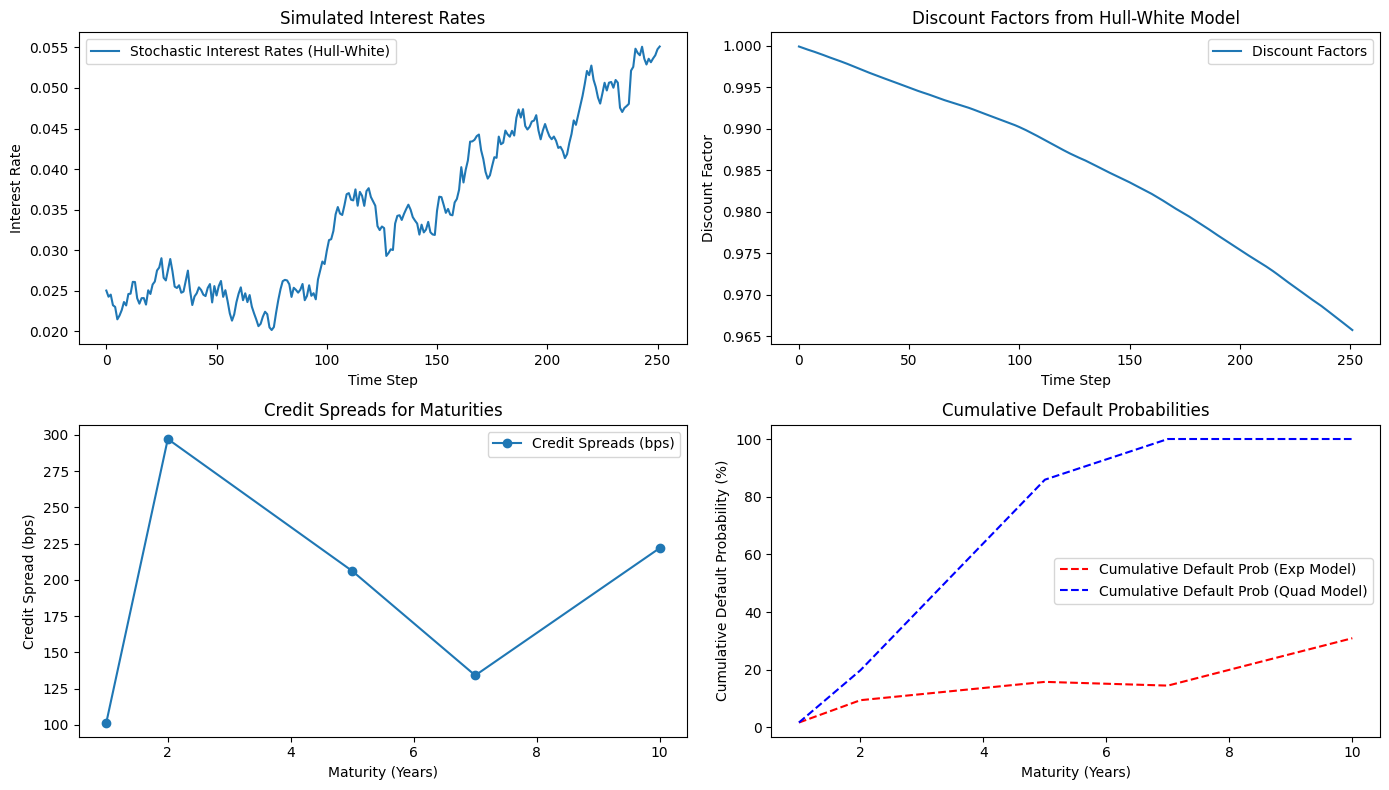

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Input
num_simulations = 10000
time_steps = 252   # Daily steps for one year
T = 1              # Time horizon in years
risk_free_rate = 0.043
funding_spread = 0.005
cost_of_capital = 0.1
capital_requirement = 0.08
default_probability = 0.01
own_default_probability = 0.008
recovery_rate = 0.4
confidence_level = 0.98
lookback_window = 20
threshold = 50000
margin_call_freq = 10
interest_rate = 0.01

# GBM Parameters for Exposure
S0 = 1
mu = 0.03
sigma = 0.2

# Simulate Exposure Profile using GBM
def simulate_exposure_gbm(S0, mu, sigma, T, steps, simulations):
    dt = T / steps
    exposures = np.zeros((simulations, steps))
    exposures[:, 0] = S0
    for t in range(1, steps):
        z = np.random.standard_normal(simulations)
        exposures[:, t] = exposures[:, t-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z)
    return exposures.mean(axis=0)

exposure_profile = simulate_exposure_gbm(S0, mu, sigma, T, time_steps, num_simulations)

# Discount Factors
discount_factors = np.exp(-np.random.normal(risk_free_rate, 0.005, time_steps) * np.arange(1, time_steps + 1) / time_steps)

# Initial Margin Profile for MVA
initial_margin_profile = np.random.uniform(0.05, 0.15, (num_simulations, time_steps))
expected_initial_margin = initial_margin_profile.mean(axis=0) * exposure_profile

# Survival Probabilities
survival_probabilities = (1 - default_probability) ** np.arange(1, time_steps + 1)
own_survival_probabilities = (1 - own_default_probability) ** np.arange(1, time_steps + 1)

cva = sum(exposure_profile[t] * (1 - recovery_rate) * discount_factors[t] * (1 - survival_probabilities[t]) for t in range(time_steps))

dva = sum(exposure_profile[t] * (1 - recovery_rate) * discount_factors[t] * (1 - own_survival_probabilities[t]) for t in range(time_steps))

fva = sum(exposure_profile[t] * funding_spread * discount_factors[t] for t in range(time_steps))

kva = sum(exposure_profile[t] * capital_requirement * cost_of_capital * discount_factors[t] for t in range(time_steps))

mva = sum(expected_initial_margin[t] * funding_spread * discount_factors[t] for t in range(time_steps))


print(f"Credit Valuation Adjustment (CVA): ${cva:.2f}")
print(f"Debit Valuation Adjustment (DVA): ${dva:.2f}")
print(f"Funding Valuation Adjustment (FVA): ${fva:.2f}")
print(f"Capital Valuation Adjustment (KVA): ${kva:.2f}")
print(f"Margin Valuation Adjustment (MVA): ${mva:.2f}")

# Dynamic Default Probabilities
maturities = np.array([1, 2, 5, 7, 10])
credit_spreads = np.random.uniform(50, 300, len(maturities)) / 10000

def exponential_model(spreads, maturities, lgd=0.6):
    return 1 - np.exp(-spreads * maturities / lgd)

def quadratic_model(spreads, maturities, lgd=0.6):
    cumulative_probabilities = spreads * (maturities**2) / lgd
    return np.minimum(cumulative_probabilities, 1)

cumulative_default_prob_exponential = exponential_model(credit_spreads, maturities)
cumulative_default_prob_quadratic = quadratic_model(credit_spreads, maturities)

spread_data = pd.DataFrame({'Maturity (Years)': maturities, 'Credit Spread': credit_spreads})
print("\nSimulated Credit Spread Data:")
print(spread_data)

prob_data = pd.DataFrame({
    'Maturity (Years)': maturities,
    'Cumulative Default Probability (Exponential)': cumulative_default_prob_exponential,
    'Cumulative Default Probability (Quadratic)': cumulative_default_prob_quadratic
})
print("\nCumulative Default Probabilities:")
print(prob_data)

exposures = np.random.normal(100000, 20000, num_simulations)
collateral = np.maximum(0, exposures - threshold)

def calculate_cva_dva_fva(exposure, collateralized=True):
    pd_counterparty = 0.02
    pd_own = 0.015
    lgd = 0.6
    exposure_net = np.maximum(0, exposure - collateral) if collateralized else exposure
    cva = pd_counterparty * lgd * np.mean(exposure_net)
    dva = pd_own * lgd * np.mean(exposure_net)
    fva = interest_rate * np.mean(exposure_net) * (0.5 if collateralized else 1)
    return cva, dva, fva

cva_collat, dva_collat, fva_collat = calculate_cva_dva_fva(exposures, collateralized=True)
cva_uncollat, dva_uncollat, fva_uncollat = calculate_cva_dva_fva(exposures, collateralized=False)

print(f"\nCollateralized CVA: ${cva_collat:.2f}")
print(f"Collateralized DVA: ${dva_collat:.2f}")
print(f"Collateralized FVA: ${fva_collat:.2f}")
print(f"Uncollateralized CVA: ${cva_uncollat:.2f}")
print(f"Uncollateralized DVA: ${dva_uncollat:.2f}")
print(f"Uncollateralized FVA: ${fva_uncollat:.2f}")

a, sigma_hw, theta, initial_rate = 0.1, 0.02, 0.03, 0.025
dt = 1/252

def simulate_hull_white(a, sigma, theta, initial_rate, num_steps, dt):
    rates = np.zeros(num_steps)
    rates[0] = initial_rate
    for t in range(1, num_steps):
        dW = np.random.normal(0, np.sqrt(dt))
        dr = a * (theta - rates[t - 1]) * dt + sigma * dW
        rates[t] = rates[t - 1] + dr
    return rates

def calculate_discount_factors(rates, dt):
    return np.exp(-np.cumsum(rates) * dt)

rates = simulate_hull_white(a, sigma_hw, theta, initial_rate, time_steps, dt)
discount_factors = calculate_discount_factors(rates, dt)
discounted_exposures = [np.sum(exposure_profile * discount_factors)]

expected_discounted_exposure = np.mean(discounted_exposures)
print("\nExpected discounted exposure:", expected_discounted_exposure)

returns = np.diff(exposures) / exposures[:-1]

def calculate_dynamic_initial_margin(returns, confidence_level, lookback_window):
    initial_margins = []
    for t in range(lookback_window, len(returns)):
        var = np.percentile(returns[t-lookback_window:t], (1 - confidence_level) * 100)
        initial_margin = -var * exposures[t]
        initial_margins.append(initial_margin)
    return initial_margins

initial_margins = calculate_dynamic_initial_margin(returns, confidence_level, lookback_window)

print("\nInitial margins over time:", initial_margins)
print("Average initial margin:", np.mean(initial_margins))

plt.figure(figsize=(14, 8))

plt.subplot(2, 2, 1)
plt.plot(rates, label='Stochastic Interest Rates (Hull-White)')
plt.xlabel("Time Step")
plt.ylabel("Interest Rate")
plt.title("Simulated Interest Rates")
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(discount_factors, label='Discount Factors')
plt.xlabel("Time Step")
plt.ylabel("Discount Factor")
plt.title("Discount Factors from Hull-White Model")
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(maturities, credit_spreads * 10000, marker='o', label='Credit Spreads (bps)')
plt.xlabel("Maturity (Years)")
plt.ylabel("Credit Spread (bps)")
plt.title("Credit Spreads for Maturities")
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(maturities, cumulative_default_prob_exponential * 100, 'r--', label='Cumulative Default Prob (Exp Model)')
plt.plot(maturities, cumulative_default_prob_quadratic * 100, 'b--', label='Cumulative Default Prob (Quad Model)')
plt.xlabel("Maturity (Years)")
plt.ylabel("Cumulative Default Probability (%)")
plt.title("Cumulative Default Probabilities")
plt.legend()

plt.tight_layout()
plt.show()


Left to do the following:

1. Use a More Granular Time Grid

	•	Problem: Using annual time steps limits precision.

	•	Solution: Increase the number of time steps (e.g., to daily or weekly), which will provide a finer-grained exposure profile.

	•	Implementation: Adjust time_steps to a higher frequency, such as time_steps = 252 for daily steps. Make sure to adjust dt accordingly in stochastic models.

2. Use Monte Carlo for Multiple Scenarios

	•	Problem: Single-path simulations may not capture tail risks accurately.

	•	Solution: Run Monte Carlo simulations with multiple scenarios (e.g., shocks to volatility, interest rates, etc.) to account for different market conditions, including extreme events.
	
	•	Implementation: Conduct multiple Monte Carlo simulations with different parameter values and aggregate results across scenarios.


Single path simulation with More Granular Time Grid

	•	Problem: Using annual time steps limits precision.

	•	Solution: Increase the number of time steps (e.g., to daily or weekly), which will provide a finer-grained exposure profile.

	•	Implementation: Adjust time_steps to a higher frequency, such as time_steps = 252 for daily steps. Make sure to adjust dt accordingly in stochastic models.

Credit Valuation Adjustment (CVA): $95.89
Debit Valuation Adjustment (DVA): $86.06
Funding Valuation Adjustment (FVA): $1.25
Capital Valuation Adjustment (KVA): $2.01
Margin Valuation Adjustment (MVA): $0.13

Simulated Credit Spread Data:
   Maturity (Years)  Credit Spread
0                 1       0.022853
1                 2       0.020674
2                 5       0.023049
3                 7       0.022237
4                10       0.010551

Cumulative Default Probabilities:
   Maturity (Years)  Cumulative Default Probability (Exponential)  \
0                 1                                      0.037372   
1                 2                                      0.066593   
2                 5                                      0.174754   
3                 7                                      0.228509   
4                10                                      0.161251   

   Cumulative Default Probability (Quadratic)  
0                                    0.038089  
1    

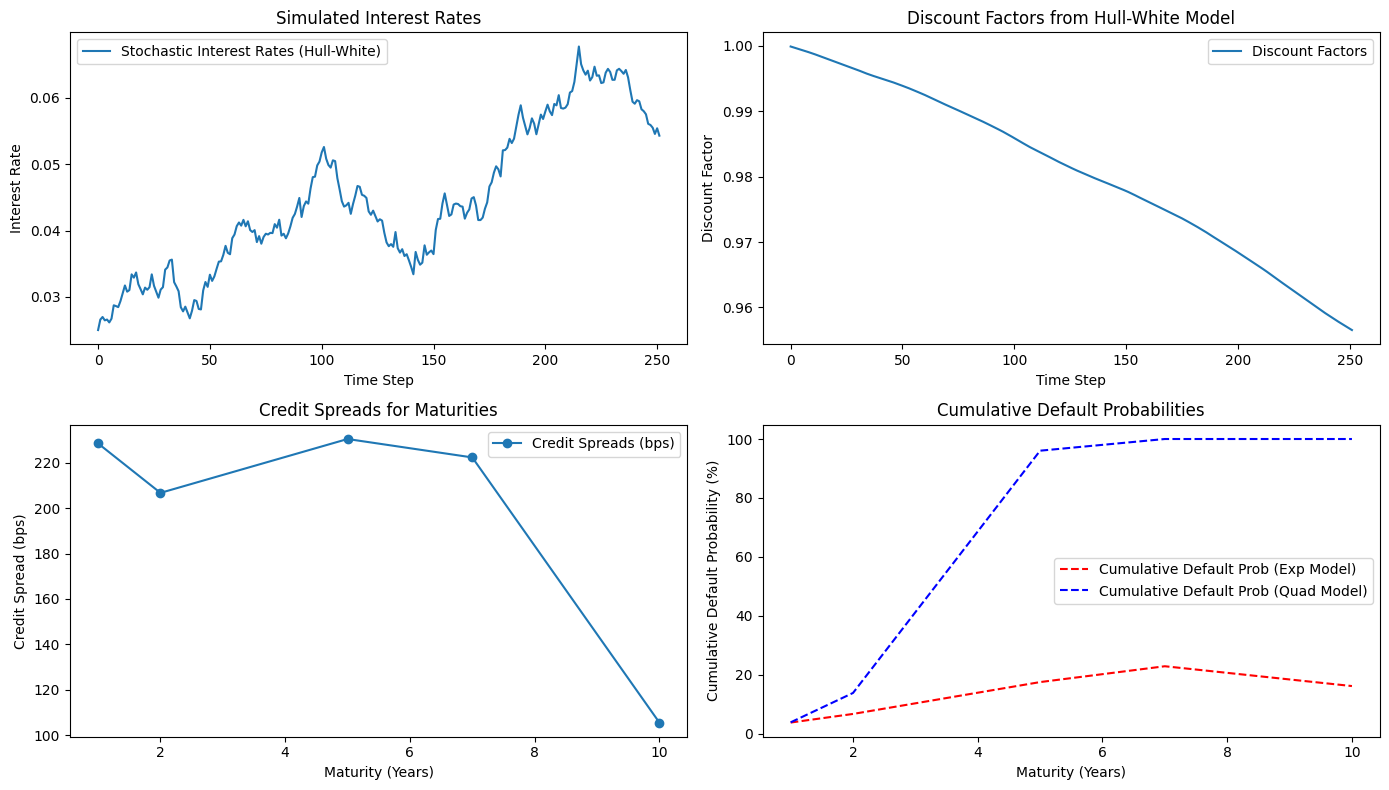

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Input
num_simulations = 10000
time_steps = 252  # Daily steps for one year
T = 1             # Time horizon in years
risk_free_rate = 0.043
funding_spread = 0.005
cost_of_capital = 0.1
capital_requirement = 0.08
default_probability = 0.01
own_default_probability = 0.008
recovery_rate = 0.4
confidence_level = 0.98
lookback_window = 20
threshold = 50000
margin_call_freq = 10
interest_rate = 0.01

# GBM Parameters for Exposure
S0 = 1
mu = 0.03
sigma = 0.2

def simulate_exposure_gbm(S0, mu, sigma, T, steps, simulations):
    dt = T / steps  # Adjusted for daily steps
    exposures = np.zeros((simulations, steps))
    exposures[:, 0] = S0
    for t in range(1, steps):
        z = np.random.standard_normal(simulations)
        exposures[:, t] = exposures[:, t-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z)
    return exposures.mean(axis=0)

exposure_profile = simulate_exposure_gbm(S0, mu, sigma, T, time_steps, num_simulations)

# Discount Factors
discount_factors = np.exp(-np.random.normal(risk_free_rate, 0.005, time_steps) * np.arange(1, time_steps + 1) / time_steps)

# Initial Margin Profile for MVA
initial_margin_profile = np.random.uniform(0.05, 0.15, (num_simulations, time_steps))
expected_initial_margin = initial_margin_profile.mean(axis=0) * exposure_profile

# Survival Probabilities
survival_probabilities = (1 - default_probability) ** np.arange(1, time_steps + 1)
own_survival_probabilities = (1 - own_default_probability) ** np.arange(1, time_steps + 1)

cva = sum(exposure_profile[t] * (1 - recovery_rate) * discount_factors[t] * (1 - survival_probabilities[t]) for t in range(time_steps))
dva = sum(exposure_profile[t] * (1 - recovery_rate) * discount_factors[t] * (1 - own_survival_probabilities[t]) for t in range(time_steps))
fva = sum(exposure_profile[t] * funding_spread * discount_factors[t] for t in range(time_steps))
kva = sum(exposure_profile[t] * capital_requirement * cost_of_capital * discount_factors[t] for t in range(time_steps))
mva = sum(expected_initial_margin[t] * funding_spread * discount_factors[t] for t in range(time_steps))

print(f"Credit Valuation Adjustment (CVA): ${cva:.2f}")
print(f"Debit Valuation Adjustment (DVA): ${dva:.2f}")
print(f"Funding Valuation Adjustment (FVA): ${fva:.2f}")
print(f"Capital Valuation Adjustment (KVA): ${kva:.2f}")
print(f"Margin Valuation Adjustment (MVA): ${mva:.2f}")

# Dynamic Default Probabilities
maturities = np.array([1, 2, 5, 7, 10])
credit_spreads = np.random.uniform(50, 300, len(maturities)) / 10000

def exponential_model(spreads, maturities, lgd=0.6):
    return 1 - np.exp(-spreads * maturities / lgd)

def quadratic_model(spreads, maturities, lgd=0.6):
    cumulative_probabilities = spreads * (maturities**2) / lgd
    return np.minimum(cumulative_probabilities, 1)

cumulative_default_prob_exponential = exponential_model(credit_spreads, maturities)
cumulative_default_prob_quadratic = quadratic_model(credit_spreads, maturities)

spread_data = pd.DataFrame({'Maturity (Years)': maturities, 'Credit Spread': credit_spreads})
print("\nSimulated Credit Spread Data:")
print(spread_data)

prob_data = pd.DataFrame({
    'Maturity (Years)': maturities,
    'Cumulative Default Probability (Exponential)': cumulative_default_prob_exponential,
    'Cumulative Default Probability (Quadratic)': cumulative_default_prob_quadratic
})
print("\nCumulative Default Probabilities:")
print(prob_data)

exposures = np.random.normal(100000, 20000, num_simulations)
collateral = np.maximum(0, exposures - threshold)

def calculate_cva_dva_fva(exposure, collateralized=True):
    pd_counterparty = 0.02
    pd_own = 0.015
    lgd = 0.6
    exposure_net = np.maximum(0, exposure - collateral) if collateralized else exposure
    cva = pd_counterparty * lgd * np.mean(exposure_net)
    dva = pd_own * lgd * np.mean(exposure_net)
    fva = interest_rate * np.mean(exposure_net) * (0.5 if collateralized else 1)
    return cva, dva, fva

cva_collat, dva_collat, fva_collat = calculate_cva_dva_fva(exposures, collateralized=True)
cva_uncollat, dva_uncollat, fva_uncollat = calculate_cva_dva_fva(exposures, collateralized=False)

print(f"\nCollateralized CVA: ${cva_collat:.2f}")
print(f"Collateralized DVA: ${dva_collat:.2f}")
print(f"Collateralized FVA: ${fva_collat:.2f}")
print(f"Uncollateralized CVA: ${cva_uncollat:.2f}")
print(f"Uncollateralized DVA: ${dva_uncollat:.2f}")
print(f"Uncollateralized FVA: ${fva_uncollat:.2f}")

a, sigma_hw, theta, initial_rate = 0.1, 0.02, 0.03, 0.025
dt = 1 / time_steps  # Daily time step adjustment

def simulate_hull_white(a, sigma, theta, initial_rate, num_steps, dt):
    rates = np.zeros(num_steps)
    rates[0] = initial_rate
    for t in range(1, num_steps):
        dW = np.random.normal(0, np.sqrt(dt))
        dr = a * (theta - rates[t - 1]) * dt + sigma * dW
        rates[t] = rates[t - 1] + dr
    return rates

def calculate_discount_factors(rates, dt):
    return np.exp(-np.cumsum(rates) * dt)

rates = simulate_hull_white(a, sigma_hw, theta, initial_rate, time_steps, dt)
discount_factors = calculate_discount_factors(rates, dt)
discounted_exposures = [np.sum(exposure_profile * discount_factors)]

expected_discounted_exposure = np.mean(discounted_exposures)
print("\nExpected discounted exposure:", expected_discounted_exposure)

returns = np.diff(exposures) / exposures[:-1]

def calculate_dynamic_initial_margin(returns, confidence_level, lookback_window):
    initial_margins = []
    for t in range(lookback_window, len(returns)):
        var = np.percentile(returns[t-lookback_window:t], (1 - confidence_level) * 100)
        initial_margin = -var * exposures[t]
        initial_margins.append(initial_margin)
    return initial_margins

initial_margins = calculate_dynamic_initial_margin(returns, confidence_level, lookback_window)

print("\nInitial margins over time:", initial_margins)
print("Average initial margin:", np.mean(initial_margins))

# Plotting
plt.figure(figsize=(14, 8))

plt.subplot(2, 2, 1)
plt.plot(rates, label='Stochastic Interest Rates (Hull-White)')
plt.xlabel("Time Step")
plt.ylabel("Interest Rate")
plt.title("Simulated Interest Rates")
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(discount_factors, label='Discount Factors')
plt.xlabel("Time Step")
plt.ylabel("Discount Factor")
plt.title("Discount Factors from Hull-White Model")
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(maturities, credit_spreads * 10000, marker='o', label='Credit Spreads (bps)')
plt.xlabel("Maturity (Years)")
plt.ylabel("Credit Spread (bps)")
plt.title("Credit Spreads for Maturities")
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(maturities, cumulative_default_prob_exponential * 100, 'r--', label='Cumulative Default Prob (Exp Model)')
plt.plot(maturities, cumulative_default_prob_quadratic * 100, 'b--', label='Cumulative Default Prob (Quad Model)')
plt.xlabel("Maturity (Years)")
plt.ylabel("Cumulative Default Probability (%)")
plt.title("Cumulative Default Probabilities")
plt.legend()

plt.tight_layout()
plt.show()


Multiple paths simulations Monte Carlo for Multiple Scenarios

	•	Problem: Single-path simulations may not capture tail risks accurately.

	•	Solution: Run Monte Carlo simulations with multiple scenarios (e.g., shocks to volatility, interest rates, etc.) to account for different market conditions, including extreme events.
	
	•	Implementation: Conduct multiple Monte Carlo simulations with different parameter values and aggregate results across scenarios.



Averaged Credit Valuation Adjustment (CVA): $95.92
Averaged Debit Valuation Adjustment (DVA): $86.08
Averaged Funding Valuation Adjustment (FVA): $1.25
Averaged Capital Valuation Adjustment (KVA): $2.01
Averaged Margin Valuation Adjustment (MVA): $0.13

Simulated Credit Spread Data:
   Maturity (Years)  Credit Spread
0                 1       0.018589
1                 2       0.028958
2                 5       0.009223
3                 7       0.011684
4                10       0.014380

Cumulative Default Probabilities:
   Maturity (Years)  Cumulative Default Probability (Exponential)  \
0                 1                                      0.030507   
1                 2                                      0.092015   
2                 5                                      0.073980   
3                 7                                      0.127427   
4                10                                      0.213104   

   Cumulative Default Probability (Quadratic)  
0      

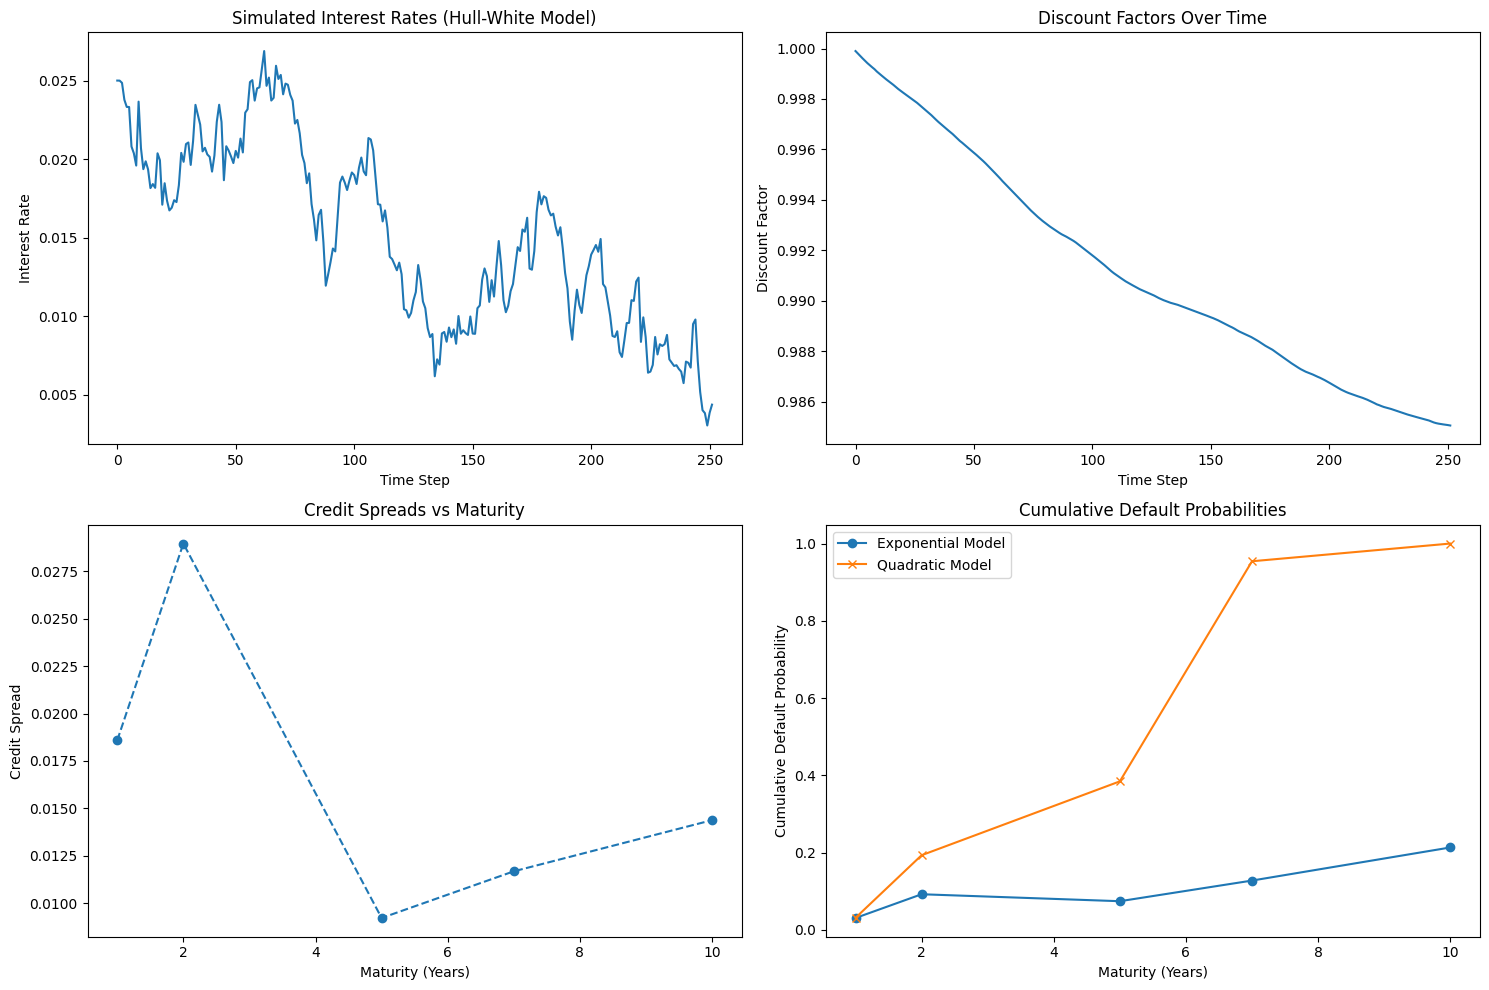

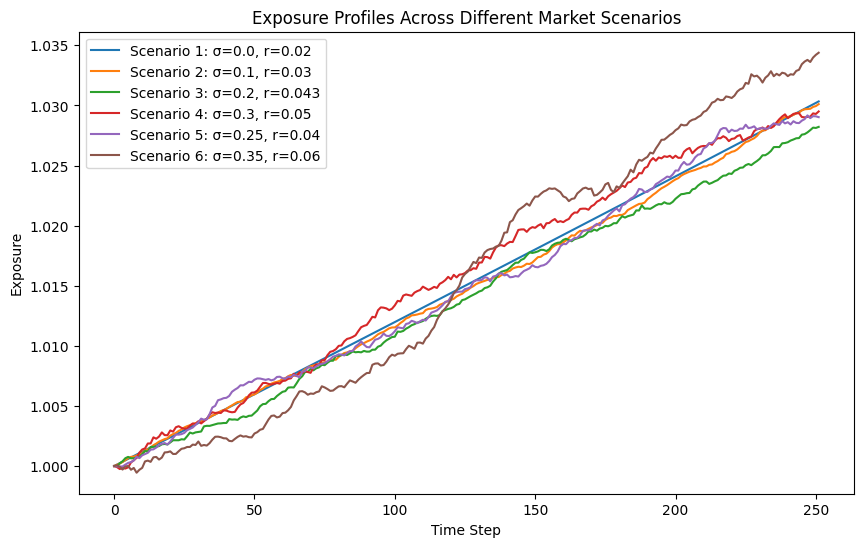

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Input
num_simulations = 10000
time_steps = 252  # Daily steps for one year
T = 1             # Time horizon in years
base_risk_free_rate = 0.043
funding_spread = 0.005
cost_of_capital = 0.1
capital_requirement = 0.08
default_probability = 0.01
own_default_probability = 0.008
recovery_rate = 0.4
confidence_level = 0.98
lookback_window = 20
threshold = 50000
margin_call_freq = 10
interest_rate = 0.01

# GBM Parameters for Exposure
S0 = 1
mu = 0.03
base_sigma = 0.2

# Input for MC
scenarios = [
    {'sigma': 0.0, 'risk_free_rate': 0.02},
    {'sigma': 0.1, 'risk_free_rate': 0.03},
    {'sigma': 0.2, 'risk_free_rate': 0.043},
    {'sigma': 0.3, 'risk_free_rate': 0.05},   # Higher volatility, higher rate
    {'sigma': 0.25, 'risk_free_rate': 0.04},  # Moderate adjustments
    {'sigma': 0.35, 'risk_free_rate': 0.06},  # Extreme conditions
]

# Function to simulate exposure profile with GBM for a given scenario
def simulate_exposure_gbm(S0, mu, sigma, T, steps, simulations):
    dt = T / steps  # Adjusted for daily steps
    exposures = np.zeros((simulations, steps))
    exposures[:, 0] = S0
    for t in range(1, steps):
        z = np.random.standard_normal(simulations)
        exposures[:, t] = exposures[:, t-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z)
    return exposures.mean(axis=0)

# Aggregating results across scenarios
cva_total, dva_total, fva_total, kva_total, mva_total = 0, 0, 0, 0, 0

for scenario in scenarios:
    sigma = scenario['sigma']
    risk_free_rate = scenario['risk_free_rate']
    
    # Simulate Exposure Profile
    exposure_profile = simulate_exposure_gbm(S0, mu, sigma, T, time_steps, num_simulations)
    
    # Discount Factors
    discount_factors = np.exp(-np.random.normal(risk_free_rate, 0.005, time_steps) * np.arange(1, time_steps + 1) / time_steps)

    # Initial Margin Profile for MVA
    initial_margin_profile = np.random.uniform(0.05, 0.15, (num_simulations, time_steps))
    expected_initial_margin = initial_margin_profile.mean(axis=0) * exposure_profile

    # Survival Probabilities
    survival_probabilities = (1 - default_probability) ** np.arange(1, time_steps + 1)
    own_survival_probabilities = (1 - own_default_probability) ** np.arange(1, time_steps + 1)


    cva = sum(exposure_profile[t] * (1 - recovery_rate) * discount_factors[t] * (1 - survival_probabilities[t]) for t in range(time_steps))
    dva = sum(exposure_profile[t] * (1 - recovery_rate) * discount_factors[t] * (1 - own_survival_probabilities[t]) for t in range(time_steps))
    fva = sum(exposure_profile[t] * funding_spread * discount_factors[t] for t in range(time_steps))
    kva = sum(exposure_profile[t] * capital_requirement * cost_of_capital * discount_factors[t] for t in range(time_steps))
    mva = sum(expected_initial_margin[t] * funding_spread * discount_factors[t] for t in range(time_steps))
    
    cva_total += cva
    dva_total += dva
    fva_total += fva
    kva_total += kva
    mva_total += mva


cva_avg = cva_total / len(scenarios)
dva_avg = dva_total / len(scenarios)
fva_avg = fva_total / len(scenarios)
kva_avg = kva_total / len(scenarios)
mva_avg = mva_total / len(scenarios)

print(f"\nAveraged Credit Valuation Adjustment (CVA): ${cva_avg:.2f}")
print(f"Averaged Debit Valuation Adjustment (DVA): ${dva_avg:.2f}")
print(f"Averaged Funding Valuation Adjustment (FVA): ${fva_avg:.2f}")
print(f"Averaged Capital Valuation Adjustment (KVA): ${kva_avg:.2f}")
print(f"Averaged Margin Valuation Adjustment (MVA): ${mva_avg:.2f}")


# Generate Credit Spread Data for demonstration purposes
maturities = np.array([1, 2, 5, 7, 10])
credit_spreads = np.random.uniform(50, 300, len(maturities)) / 10000

def exponential_model(spreads, maturities, lgd=0.6):
    return 1 - np.exp(-spreads * maturities / lgd)

def quadratic_model(spreads, maturities, lgd=0.6):
    cumulative_probabilities = spreads * (maturities**2) / lgd
    return np.minimum(cumulative_probabilities, 1)

cumulative_default_prob_exponential = exponential_model(credit_spreads, maturities)
cumulative_default_prob_quadratic = quadratic_model(credit_spreads, maturities)

spread_data = pd.DataFrame({'Maturity (Years)': maturities, 'Credit Spread': credit_spreads})
print("\nSimulated Credit Spread Data:")
print(spread_data)

prob_data = pd.DataFrame({
    'Maturity (Years)': maturities,
    'Cumulative Default Probability (Exponential)': cumulative_default_prob_exponential,
    'Cumulative Default Probability (Quadratic)': cumulative_default_prob_quadratic
})
print("\nCumulative Default Probabilities:")
print(prob_data)

exposures = np.random.normal(100000, 20000, num_simulations)
collateral = np.maximum(0, exposures - threshold)

def calculate_cva_dva_fva(exposure, collateralized=True):
    pd_counterparty = 0.02
    pd_own = 0.015
    lgd = 0.6
    exposure_net = np.maximum(0, exposure - collateral) if collateralized else exposure
    cva = pd_counterparty * lgd * np.mean(exposure_net)
    dva = pd_own * lgd * np.mean(exposure_net)
    fva = interest_rate * np.mean(exposure_net) * (0.5 if collateralized else 1)
    return cva, dva, fva

cva_collat, dva_collat, fva_collat = calculate_cva_dva_fva(exposures, collateralized=True)
cva_uncollat, dva_uncollat, fva_uncollat = calculate_cva_dva_fva(exposures, collateralized=False)

print(f"\nCollateralized CVA: ${cva_collat:.2f}")
print(f"Collateralized DVA: ${dva_collat:.2f}")
print(f"Collateralized FVA: ${fva_collat:.2f}")
print(f"Uncollateralized CVA: ${cva_uncollat:.2f}")
print(f"Uncollateralized DVA: ${dva_uncollat:.2f}")
print(f"Uncollateralized FVA: ${fva_uncollat:.2f}")

a, sigma_hw, theta, initial_rate = 0.1, 0.02, 0.03, 0.025
dt = 1 / time_steps  # Daily time step adjustment

def simulate_hull_white(a, sigma, theta, initial_rate, num_steps, dt):
    rates = np.zeros(num_steps)
    rates[0] = initial_rate
    for t in range(1, num_steps):
        dW = np.random.normal(0, np.sqrt(dt))
        dr = a * (theta - rates[t - 1]) * dt + sigma * dW
        rates[t] = rates[t - 1] + dr
    return rates

def calculate_discount_factors(rates, dt):
    return np.exp(-np.cumsum(rates) * dt)

rates = simulate_hull_white(a, sigma_hw, theta, initial_rate, time_steps, dt)
discount_factors = calculate_discount_factors(rates, dt)
discounted_exposures = [np.sum(exposure_profile * discount_factors)]

expected_discounted_exposure = np.mean(discounted_exposures)
print("\nExpected discounted exposure:", expected_discounted_exposure)

print("\nInitial margins over time:", initial_margins)
print("Average initial margin:", np.mean(initial_margins))

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(rates)
plt.title("Simulated Interest Rates (Hull-White Model)")
plt.xlabel("Time Step")
plt.ylabel("Interest Rate")

plt.subplot(2, 2, 2)
plt.plot(discount_factors)
plt.title("Discount Factors Over Time")
plt.xlabel("Time Step")
plt.ylabel("Discount Factor")

plt.subplot(2, 2, 3)
plt.plot(maturities, credit_spreads, marker='o', linestyle='--')
plt.title("Credit Spreads vs Maturity")
plt.xlabel("Maturity (Years)")
plt.ylabel("Credit Spread")

plt.subplot(2, 2, 4)
plt.plot(maturities, cumulative_default_prob_exponential, label='Exponential Model', marker='o')
plt.plot(maturities, cumulative_default_prob_quadratic, label='Quadratic Model', marker='x')
plt.title("Cumulative Default Probabilities")
plt.xlabel("Maturity (Years)")
plt.ylabel("Cumulative Default Probability")
plt.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
for i, scenario in enumerate(scenarios):
    sigma = scenario['sigma']
    risk_free_rate = scenario['risk_free_rate']
    exposure_profile = simulate_exposure_gbm(S0, mu, sigma, T, time_steps, num_simulations)
    plt.plot(exposure_profile, label=f'Scenario {i+1}: σ={sigma}, r={risk_free_rate}')

plt.xlabel("Time Step")
plt.ylabel("Exposure")
plt.title("Exposure Profiles Across Different Market Scenarios")
plt.legend()
plt.show()